In [1]:
# Includes
# os
import os
from time import sleep
import datetime
from datetime import timezone

# websockets and connectivity
from binance.websockets import BinanceSocketManager
from twisted.internet import reactor

# interactive shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# binance
from binance.client import Client
import binance.helpers as btime

# pandas
import pandas as pd
from pandas import DataFrame as df
pd.set_option("display.max_rows", 100, "display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# numpy
import numpy as np

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics import tsaplots


# data science utils
from scipy import stats
from scipy import fft
from scipy import signal
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pingouin as pg

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load api login data

# open api login file
apifile = open("apilogin.txt", "r");
apilogin = (str(apifile.read()).split("\n"));

# extract key
apikey = apilogin[0].split(":")[1];
# extract secret
apisecret = apilogin[1].split(":")[1];

# check values
"key: " + apikey;
"secret: " + apisecret;

client=Client(api_key=apikey,api_secret=apisecret);

In [3]:
# define trade pair
base_asset = 'ETH'
quote_asset = 'BTC'
trade_pair = base_asset+quote_asset

# define request interval
time_interval = Client.KLINE_INTERVAL_1MINUTE

# define initial start as utc timestamp
start_time = btime.date_to_milliseconds('Dec 1, 2020')

# request initial historical data
candles = client.get_historical_klines(symbol=trade_pair,interval=time_interval, start_str=start_time,limit=1000)


In [4]:
len(candles)
# Verify the last known data point is today
end_unix_timestamp = candles[-1][0]/1000
datetime.datetime.fromtimestamp(end_unix_timestamp)

577020

datetime.datetime(2022, 1, 6, 9, 22)

In [5]:
# Dynamically name headers
kline_headers = ['Open Time UTC', 
    'Open ' + quote_asset, 
    'High ' + quote_asset, 
    'Low ' + quote_asset, 
    'Close ' + quote_asset, 
    'Volume ' + base_asset, 
    'Close Time UTC', 
    'Volume ' + quote_asset, 
    'Number of Trades',
    'Taker Buy Volume ' + base_asset,
    'Taker Buy Volume ' + quote_asset]
# kline_headers

In [6]:
# Create key-value pairs for each column and associated numpy dtype
typedict = {
    kline_headers[0]: np.uint64,
    kline_headers[1]: np.float32,
    kline_headers[2]: np.float32,
    kline_headers[3]: np.float32,
    kline_headers[4]: np.float32,
    kline_headers[5]: np.float32,
    kline_headers[6]: np.uint64,
    kline_headers[7]: np.float32,
    kline_headers[8]: np.float32,
    kline_headers[9]: np.float32,
    kline_headers[10]: np.float32,
}

# Instantiate klines dataframe and assign dtypes via dictionary
klines = df(data=[entry[:-1] for entry in candles], columns=kline_headers).astype(typedict)

# Sort klines dataframe by ascending UTC open
klines.sort_values(by=['Open Time UTC'], ascending=True, inplace=True)

# Assign open UTC as index
klines.index = klines['Open Time UTC']

print('Kline data types:')
klines.dtypes

# klines.head()

Kline data types:


Open Time UTC            uint64
Open BTC                float32
High BTC                float32
Low BTC                 float32
Close BTC               float32
Volume ETH              float32
Close Time UTC           uint64
Volume BTC              float32
Number of Trades        float32
Taker Buy Volume ETH    float32
Taker Buy Volume BTC    float32
dtype: object

In [7]:
# calculate close-open differences for each period
klines['Difference ' + quote_asset] = klines['Close ' + quote_asset]-klines['Open ' + quote_asset]
klines['Percent Change ' + quote_asset] = 100 * klines['Difference ' + quote_asset] / klines['Open ' + quote_asset]
klines.head()

Open Time UTC  Open BTC  High BTC  Low BTC  Close BTC  \
Open Time UTC                                                          
1606780800000  1606780800000   0.03131   0.03132  0.03125    0.03125   
1606780860000  1606780860000   0.03125   0.03130  0.03125    0.03127   
1606780920000  1606780920000   0.03126   0.03134  0.03126    0.03133   
1606780980000  1606780980000   0.03133   0.03137  0.03132    0.03137   
1606781040000  1606781040000   0.03137   0.03140  0.03134    0.03137   

               Volume ETH  Close Time UTC  Volume BTC  Number of Trades  \
Open Time UTC                                                             
1606780800000   332.94400   1606780859999    10.41869         285.00000   
1606780860000   347.59900   1606780919999    10.87070         246.00000   
1606780920000   348.82599   1606780979999    10.92332         232.00000   
1606780980000   377.57199   1606781039999    11.83920         302.00000   
1606781040000   689.13098   1606781099999    21.61878         317.00000   

               Taker Buy Volume ETH  Taker Buy Volume BTC  Difference BTC  \
Open Time UTC                                                               
1606780800000             120.16900               3.76137        -0.00006   
1606780860000             169.12000               5.28886         0.00002   
1606780920000             252.61099               7.91123         0.00007   
1606780980000             284.16000               8.91018         0.00004   
1606781040000             462.52200              14.50975        -0.00000   

               Percent Change BTC  
Open Time UTC                      
1606780800000            -0.20121  
1606780860000             0.06081  
1606780920000             0.23030  
1606780980000             0.12127  
1606781040000            -0.01274

In [8]:
# create Maker-Taker ratio
klines['Maker-Taker Volume ' + quote_asset + ' Ratio'] = ((klines['Volume ' + quote_asset] - klines['Taker Buy Volume ' + quote_asset]) / klines['Volume ' + quote_asset])

# create generic Ratios
klines['Price-Volume ' + quote_asset + ' Ratio'] = klines['Open ' + quote_asset] / klines['Volume ' + quote_asset]
klines['Trade-Volume ' + quote_asset + ' Ratio'] = klines['Number of Trades']/klines['Volume ' + quote_asset]
klines['Price-Taker Buy Volume ' + quote_asset + ' Ratio'] = klines['Open ' + quote_asset] / klines['Taker Buy Volume ' + quote_asset]
klines['Trade-Taker Buy Volume ' + quote_asset + ' Ratio'] = klines['Number of Trades']/klines['Taker Buy Volume ' + quote_asset]

In [9]:
# Differentials lagged by 1 timestep
# so that all diff columns are predictors

klines_diff_1 = klines.diff(axis='index',periods=1).shift(1)
klines_diff_1.columns = ['DIFF 1 ' + colname for colname in klines.columns]
klines_diff_1.drop(columns=[klines_diff_1.columns[0], klines_diff_1.columns[6]], inplace=True)

klines_diff_2 = klines.diff(axis='index',periods=2).shift(1)
klines_diff_2.columns = ['DIFF 2 ' + colname for colname in klines.columns]
klines_diff_2.drop(columns=[klines_diff_2.columns[0], klines_diff_2.columns[6]], inplace=True)

klines_diff_3 = klines.diff(axis='index',periods=3).shift(1)
klines_diff_3.columns = ['DIFF 3 ' + colname for colname in klines.columns]
klines_diff_3.drop(columns=[klines_diff_3.columns[0], klines_diff_3.columns[6]], inplace=True)


In [10]:
klines = klines.join(klines_diff_1,how='inner').join(klines_diff_2,how='inner').join(klines_diff_3,how='inner')
klines.head()

Open Time UTC  Open BTC  High BTC  Low BTC  Close BTC  \
Open Time UTC                                                          
1606780800000  1606780800000   0.03131   0.03132  0.03125    0.03125   
1606780860000  1606780860000   0.03125   0.03130  0.03125    0.03127   
1606780920000  1606780920000   0.03126   0.03134  0.03126    0.03133   
1606780980000  1606780980000   0.03133   0.03137  0.03132    0.03137   
1606781040000  1606781040000   0.03137   0.03140  0.03134    0.03137   

               Volume ETH  Close Time UTC  Volume BTC  Number of Trades  \
Open Time UTC                                                             
1606780800000   332.94400   1606780859999    10.41869         285.00000   
1606780860000   347.59900   1606780919999    10.87070         246.00000   
1606780920000   348.82599   1606780979999    10.92332         232.00000   
1606780980000   377.57199   1606781039999    11.83920         302.00000   
1606781040000   689.13098   1606781099999    21.61878         317.00000   

               Taker Buy Volume ETH  Taker Buy Volume BTC  Difference BTC  \
Open Time UTC                                                               
1606780800000             120.16900               3.76137        -0.00006   
1606780860000             169.12000               5.28886         0.00002   
1606780920000             252.61099               7.91123         0.00007   
1606780980000             284.16000               8.91018         0.00004   
1606781040000             462.52200              14.50975        -0.00000   

               Percent Change BTC  Maker-Taker Volume BTC Ratio  \
Open Time UTC                                                     
1606780800000            -0.20121                       0.63898   
1606780860000             0.06081                       0.51348   
1606780920000             0.23030                       0.27575   
1606780980000             0.12127                       0.24740   
1606781040000            -0.01274                       0.32884   

               Price-Volume BTC Ratio  Trade-Volume BTC Ratio  \
Open Time UTC                                                   
1606780800000                 0.00301                27.35468   
1606780860000                 0.00287                22.62963   
1606780920000                 0.00286                21.23897   
1606780980000                 0.00265                25.50847   
1606781040000                 0.00145                14.66317   

               Price-Taker Buy Volume BTC Ratio  \
Open Time UTC                                     
1606780800000                           0.00832   
1606780860000                           0.00591   
1606780920000                           0.00395   
1606780980000                           0.00352   
1606781040000                           0.00216   

               Trade-Taker Buy Volume BTC Ratio  DIFF 1 Open BTC  \
Open Time UTC                                                      
1606780800000                          75.77024              NaN   
1606780860000                          46.51286              NaN   
1606780920000                          29.32539         -0.00006   
1606780980000                          33.89380          0.00002   
1606781040000                          21.84738          0.00007   

               DIFF 1 High BTC  DIFF 1 Low BTC  DIFF 1 Close BTC  \
Open Time UTC                                                      
1606780800000              NaN             NaN               NaN   
1606780860000              NaN             NaN               NaN   
1606780920000         -0.00002         0.00000           0.00002   
1606780980000          0.00004         0.00001           0.00007   
1606781040000          0.00003         0.00006           0.00004   

               DIFF 1 Volume ETH  DIFF 1 Volume BTC  DIFF 1 Number of Trades  \
Open Time UTC                                                                  
1606780800000                NaN              

In [11]:
# Verify no NaNs except in first three rows, then remove them in place
klines[klines.isna().any(axis=1)].head()
klines[klines.isna().any(axis=1)].shape
klines.drop(axis='index', labels=klines[klines.isna().any(axis=1)]['Open Time UTC'].values.tolist(),inplace=True)


Open Time UTC  Open BTC  High BTC  Low BTC  Close BTC  \
Open Time UTC                                                          
1606780800000  1606780800000   0.03131   0.03132  0.03125    0.03125   
1606780860000  1606780860000   0.03125   0.03130  0.03125    0.03127   
1606780920000  1606780920000   0.03126   0.03134  0.03126    0.03133   
1606780980000  1606780980000   0.03133   0.03137  0.03132    0.03137   
1608556800000  1608556800000   0.02686   0.02686  0.02686    0.02686   

               Volume ETH  Close Time UTC  Volume BTC  Number of Trades  \
Open Time UTC                                                             
1606780800000   332.94400   1606780859999    10.41869         285.00000   
1606780860000   347.59900   1606780919999    10.87070         246.00000   
1606780920000   348.82599   1606780979999    10.92332         232.00000   
1606780980000   377.57199   1606781039999    11.83920         302.00000   
1608556800000     0.00000   1608556859999     0.00000           0.00000   

               Taker Buy Volume ETH  Taker Buy Volume BTC  Difference BTC  \
Open Time UTC                                                               
1606780800000             120.16900               3.76137        -0.00006   
1606780860000             169.12000               5.28886         0.00002   
1606780920000             252.61099               7.91123         0.00007   
1606780980000             284.16000               8.91018         0.00004   
1608556800000               0.00000               0.00000         0.00000   

               Percent Change BTC  Maker-Taker Volume BTC Ratio  \
Open Time UTC                                                     
1606780800000            -0.20121                       0.63898   
1606780860000             0.06081                       0.51348   
1606780920000             0.23030                       0.27575   
1606780980000             0.12127                       0.24740   
1608556800000             0.00000                           NaN   

               Price-Volume BTC Ratio  Trade-Volume BTC Ratio  \
Open Time UTC                                                   
1606780800000                 0.00301                27.35468   
1606780860000                 0.00287                22.62963   
1606780920000                 0.00286                21.23897   
1606780980000                 0.00265                25.50847   
1608556800000                     inf                     NaN   

               Price-Taker Buy Volume BTC Ratio  \
Open Time UTC                                     
1606780800000                           0.00832   
1606780860000                           0.00591   
1606780920000                           0.00395   
1606780980000                           0.00352   
1608556800000                               inf   

               Trade-Taker Buy Volume BTC Ratio  DIFF 1 Open BTC  \
Open Time UTC                                                      
1606780800000                          75.77024              NaN   
1606780860000                          46.51286              NaN   
1606780920000                          29.32539         -0.00006   
1606780980000                          33.89380          0.00002   
1608556800000                               NaN         -0.00002   

               DIFF 1 High BTC  DIFF 1 Low BTC  DIFF 1 Close BTC  \
Open Time UTC                                                      
1606780800000              NaN             NaN               NaN   
1606780860000              NaN             NaN               NaN   
1606780920000         -0.00002         0.00000           0.00002   
1606780980000          0.00004         0.00001           0.00007   
1608556800000         -0.00002        -0.00000           0.00002   

               DIFF 1 Volume ETH  DIFF 1 Volume BTC  DIFF 1 Number of Trades  \
Open Time UTC                                                                  
1606780800000                NaN              

(164, 66)

In [12]:
# Create df for price data only
price_df = df(klines['Open ' + quote_asset])
price_df.columns=['Price']
price_df.head()

# start with 1st order linear model
time_idx = price_df.index.to_numpy()
price = price_df.Price.to_numpy()
order1_regression = stats.linregress(time_idx,price)
order1_prediction = order1_regression.intercept + order1_regression.slope*time_idx
order1_residual = price-order1_prediction

Price
Open Time UTC        
1606781040000 0.03137
1606781100000 0.03137
1606781160000 0.03140
1606781220000 0.03138
1606781280000 0.03132

<Figure size 1440x288 with 0 Axes>

Text(0.5, 1.0, 'Price History (USD) ')

Text(0.5, 0, 'UTC Timestamp (s)')

Text(0, 0.5, 'Price ($USD)')

<Figure size 1440x288 with 0 Axes>

Text(0.5, 1.0, '')

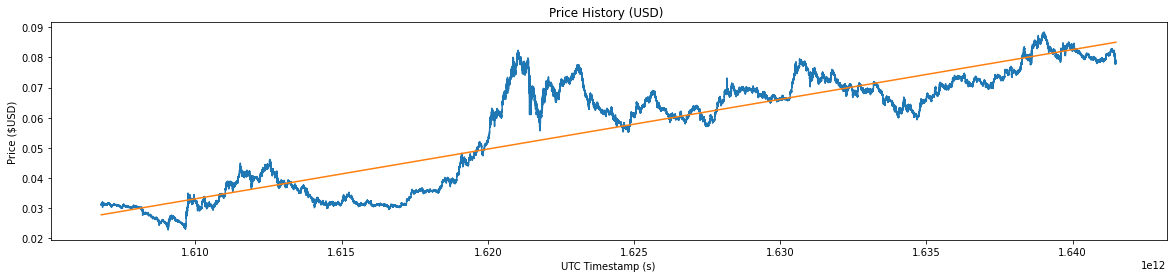

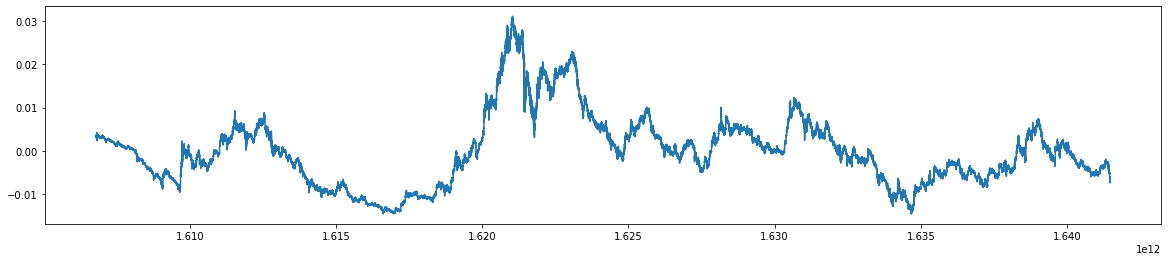

In [13]:

# Graph true price vs 1st order approximation
plt.figure(figsize=(20,4));
plt.plot(time_idx, price)
plt.plot(time_idx, order1_prediction)
plt.title('Price History (USD) ')
plt.xlabel('UTC Timestamp (s)')
plt.ylabel('Price ($USD)')

# Graph 1st order residual 
plt.figure(figsize=(20,4))
plt.plot(time_idx, order1_residual)
plt.title('')

In [14]:
# remove DC component of order 1 residual
order1_residual = order1_residual - np.mean(order1_residual)

# n = signal length
n = price.size

# T = spacing
timestep = 1/(24*60) # unit is days

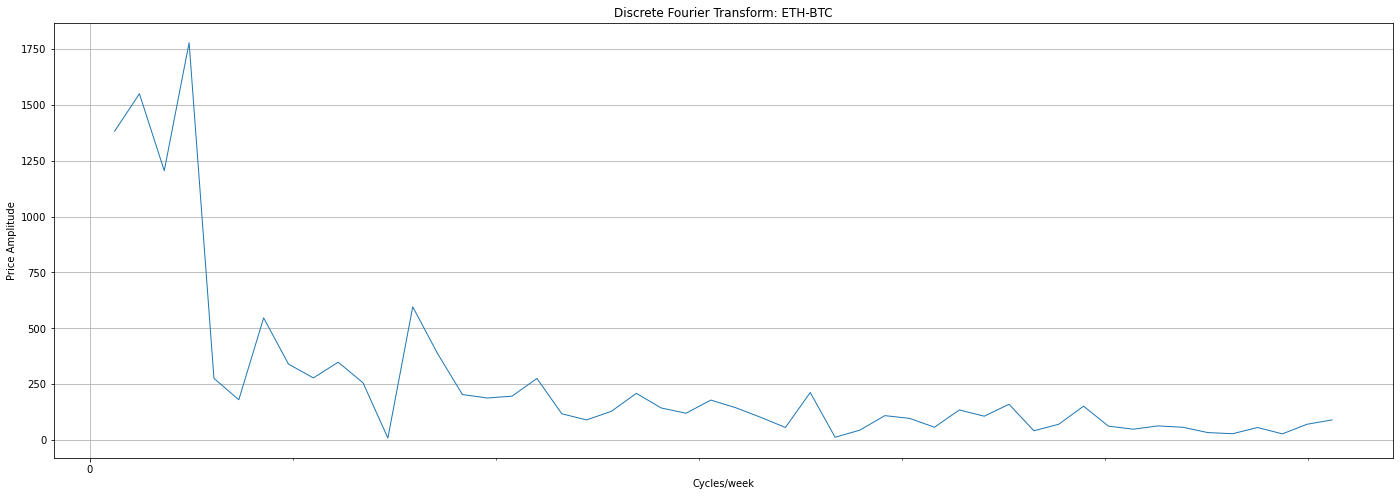

In [15]:
# Raw signal FFT
price_fft = fft.fft(order1_residual,norm=None)[1:n//2] # fft amplitude of pair price 
fft_freq = 7*fft.fftfreq(n, timestep)[1:n//2] # cycles per week
fft_period = 1/fft_freq # period in weeks

# Plot FFT by frequency
plt.figure(figsize=(24,8));
ax = plt.gca();
ax.plot(fft_freq[:50], (np.abs(price_fft[:50])),linewidth=1);
plt.grid();
plt.title('Discrete Fourier Transform: ' + base_asset + '-' + quote_asset);
plt.ylabel('Price Amplitude');
plt.xlabel('Cycles/week');
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1/7));
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1));

# # Plot FFT by wavelength
# plt.figure(figsize=(24,8))
# ax = plt.gca()
# ax.plot(fft_period, (np.abs(price_fft)),linewidth=1,marker='o')
# plt.grid()
# plt.title('Discrete Fourier Transform: ' + base_asset + '-' + quote_asset)
# plt.ylabel('Price Amplitude');
# plt.xlabel('Period (week)');

In [16]:
fft_data = df(data=[np.abs(price_fft[0:10]),fft_freq[0:10]],index=['Price Amplitude','Cycles per Week']).transpose()
fft_data['Cycle Period (Days)'] = 7/fft_data['Cycles per Week']
fft_data

Price Amplitude  Cycles per Week  Cycle Period (Days)
0       1382.18137          0.01747            400.59444
1       1550.17458          0.03495            200.29722
2       1205.60322          0.05242            133.53148
3       1778.98307          0.06990            100.14861
4        275.45627          0.08737             80.11889
5        179.75720          0.10484             66.76574
6        546.25039          0.12232             57.22778
7        339.33163          0.13979             50.07431
8        277.48344          0.15727             44.51049
9        347.98698          0.17474             40.05944

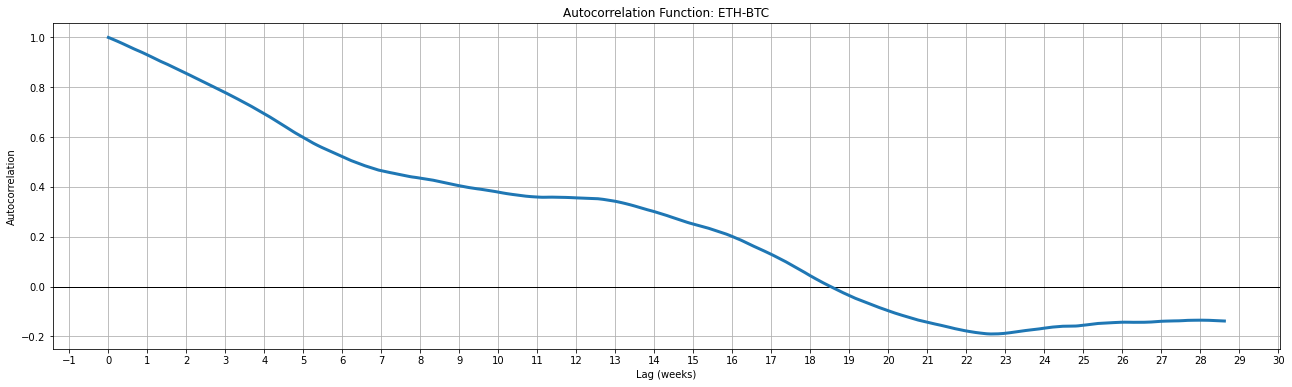

In [17]:
# Raw signal
order0_residual = price-np.mean(price) # remove DC component
ac_residual = np.correlate(order0_residual, order0_residual, 'same')[n//2+1:] # calucate autocorrelation
ac_residual /= ac_residual[0] # normalize by first value

lag = np.arange(len(ac_residual))*(1/(60*24))/7 # lag in weeks

# plot autocorrelation
plt.figure(figsize=(22,6));
ax = plt.gca();
plt.axhline(y=0, color='k',linewidth=1);
plt.plot(lag, ac_residual, linewidth=3);
plt.grid();
plt.title('Autocorrelation Function: ' + base_asset + '-' + quote_asset);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag (weeks)');
ax.xaxis.set_major_locator(plt.MultipleLocator(1));

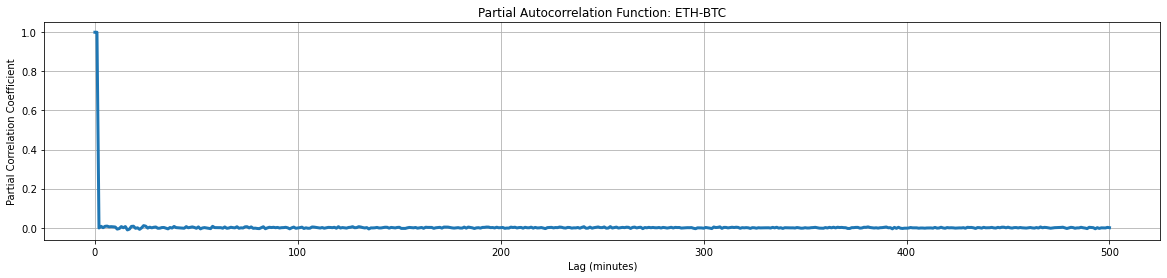

In [18]:
# Partial Autocorrelation
plt.figure(figsize=(20,4));
pac = sm.tsa.stattools.pacf(order0_residual, nlags=500, method='ld');
plt.plot(np.arange(len(pac)), pac, linewidth=3);
plt.grid();
plt.title('Partial Autocorrelation Function: ' + base_asset + '-' + quote_asset);
plt.ylabel('Partial Correlation Coefficient');
plt.xlabel('Lag (minutes)');



In [19]:
# Drop time columns as DF in indexed by UTC timestamp
complete_data = klines.drop(['Open Time UTC','Close Time UTC'],axis='columns')

# add lagged data to complete_data
lag1 = complete_data.shift(1).drop(labels=['Open ' + quote_asset, 'High ' + quote_asset, 'Low ' + quote_asset, 'Close ' + quote_asset],axis='columns').drop(labels=[x for x in klines.columns if 'DIFF ' in x], axis='columns').rename(columns={x: 'LAG 1 ' + x for x in klines.columns})
lag2 = complete_data.shift(2).drop(labels=['Open ' + quote_asset, 'High ' + quote_asset, 'Low ' + quote_asset, 'Close ' + quote_asset],axis='columns').drop(labels=[x for x in klines.columns if 'DIFF ' in x], axis='columns').rename(columns={x: 'LAG 2 ' + x for x in klines.columns})
lag3 = complete_data.shift(3).drop(labels=['Open ' + quote_asset, 'High ' + quote_asset, 'Low ' + quote_asset, 'Close ' + quote_asset],axis='columns').drop(labels=[x for x in klines.columns if 'DIFF ' in x], axis='columns').rename(columns={x: 'LAG 3 ' + x for x in klines.columns})

complete_data = complete_data.join(other=[lag1,lag2,lag3],how='inner').dropna()


In [20]:
# df(complete_data.columns)
complete_data.head()
print('Augmented Kline data shape: ')
complete_data.shape

Open BTC  High BTC  Low BTC  Close BTC  Volume ETH  Volume BTC  \
Open Time UTC                                                                   
1606781220000   0.03138   0.03138  0.03132    0.03132   242.86301     7.61350   
1606781280000   0.03132   0.03134  0.03132    0.03134   120.73700     3.78288   
1606781340000   0.03135   0.03136  0.03132    0.03132    85.66000     2.68420   
1606781400000   0.03132   0.03133  0.03128    0.03129   241.74100     7.56672   
1606781460000   0.03129   0.03129  0.03126    0.03128   322.33600    10.07831   

               Number of Trades  Taker Buy Volume ETH  Taker Buy Volume BTC  \
Open Time UTC                                                                 
1606781220000         177.00000              93.79800               2.94024   
1606781280000         106.00000              59.62500               1.86821   
1606781340000         107.00000              48.02700               1.50500   
1606781400000         134.00000              57.44500               1.79795   
1606781460000         172.00000              64.43000               2.01451   

               Difference BTC  Percent Change BTC  \
Open Time UTC                                       
1606781220000        -0.00006            -0.19118   
1606781280000         0.00002             0.06386   
1606781340000        -0.00003            -0.09252   
1606781400000        -0.00003            -0.10854   
1606781460000        -0.00002            -0.05113   

               Maker-Taker Volume BTC Ratio  Price-Volume BTC Ratio  \
Open Time UTC                                                         
1606781220000                       0.61381                 0.00412   
1606781280000                       0.50614                 0.00828   
1606781340000                       0.43931                 0.01168   
1606781400000                       0.76239                 0.00414   
1606781460000                       0.80011                 0.00310   

               Trade-Volume BTC Ratio  Price-Taker Buy Volume BTC Ratio  \
Open Time UTC                                                             
1606781220000                23.24816                           0.01067   
1606781280000                28.02096                           0.01677   
1606781340000                39.86286                           0.02083   
1606781400000                17.70913                           0.01742   
1606781460000                17.06636                           0.01553   

               Trade-Taker Buy Volume BTC Ratio  DIFF 1 Open BTC  \
Open Time UTC                                                      
1606781220000                          60.19922          0.00004   
1606781280000                          56.73886         -0.00002   
1606781340000                          71.09628         -0.00006   
1606781400000                          74.52953          0.00002   
1606781460000                          85.38051         -0.00002   

               DIFF 1 High BTC  DIFF 1 Low BTC  DIFF 1 Close BTC  \
Open Time UTC                                                      
1606781220000          0.00002         0.00001          -0.00002   
1606781280000         -0.00005        -0.00006          -0.00006   
1606781340000         -0.00004        -0.00000           0.00002   
1606781400000          0.00001        -0.00000          -0.00003   
1606781460000         -0.00002        -0.00003          -0.00003   

               DIFF 1 Volume ETH  DIFF 1 Volume BTC  DIFF 1 Number of Trades  \
Open Time UTC                                                                  
1606781220000          297.32901            9.35025                155.00000   
1606781280000         -427.18399          -13.43628               -203.00000   
1606781340000         -122.12601           -3.83062                -71.00000   
1606781400000          -35.07700           -1.09868                  1.00000   
1606781460000          156.08099            4.88252            

Augmented Kline data shape: 


(576853, 100)

In [22]:
# Plot correlation between pairs except for lag
pairplot = sb.pairplot(complete_data[[col for col in complete_data.columns if 'LAG' not in col]].sample(n=1600, axis='index'), diag_kind='kde', kind='scatter',height=2, corner=True,plot_kws=dict(marker='+',linewidth=1))

pairplot.savefig('pairplot_' + trade_pair + '.png',transparent=False)

In [23]:
# Collect pairwise correlation into dataframe
pairwise = pg.pairwise_corr(complete_data.sample(16000), method='spearman', # use spearman correlation to look for monotonically varying pairs
    alternative='two-sided',padjust='bonf').sort_values(by='r',ascending=False)
pairwise

X  \
100                                  High BTC   
197                                   Low BTC   
0                                    Open BTC   
1                                    Open BTC   
2                                    Open BTC   
...                                       ...   
4315  DIFF 3 Trade-Taker Buy Volume BTC Ratio   
4316  DIFF 3 Trade-Taker Buy Volume BTC Ratio   
4317  DIFF 3 Trade-Taker Buy Volume BTC Ratio   
4318  DIFF 3 Trade-Taker Buy Volume BTC Ratio   
4319  DIFF 3 Trade-Taker Buy Volume BTC Ratio   

                                           Y    method alternative      n  \
100                                Close BTC  spearman   two-sided  16000   
197                                Close BTC  spearman   two-sided  16000   
0                                   High BTC  spearman   two-sided  16000   
1                                    Low BTC  spearman   two-sided  16000   
2                                  Close BTC  spearman   two-sided  16000   
...                                      ...       ...         ...    ...   
4315      LAG 3 Maker-Taker Volume BTC Ratio  spearman   two-sided  16000   
4316            LAG 3 Price-Volume BTC Ratio  spearman   two-sided  16000   
4317            LAG 3 Trade-Volume BTC Ratio  spearman   two-sided  16000   
4318  LAG 3 Price-Taker Buy Volume BTC Ratio  spearman   two-sided  16000   
4319  LAG 3 Trade-Taker Buy Volume BTC Ratio  spearman   two-sided  16000   

           r       CI95%   p-unc  p-corr p-adjust   power  
100  0.99999  [1.0, 1.0] 0.00000 0.00000     bonf 1.00000  
197  0.99999  [1.0, 1.0] 0.00000 0.00000     bonf 1.00000  
0    0.99999  [1.0, 1.0] 0.00000 0.00000     bonf 1.00000  
1    0.99999  [1.0, 1.0] 0.00000 0.00000     bonf 1.00000  
2    0.99999  [1.0, 1.0] 0.00000 0.00000     bonf 1.00000  
...      ...         ...     ...     ...      ...     ...  
4315     NaN         NaN     NaN     NaN     bonf     NaN  
4316     NaN         NaN     NaN     NaN     bonf     NaN  
4317     NaN         NaN     NaN     NaN     bonf     NaN  
4318     NaN         NaN     NaN     NaN     bonf     NaN  
4319     NaN         NaN     NaN     NaN     bonf     NaN  

[4950 rows x 11 columns]

In [24]:
# Clean up pairwise data and copy to new DF 
corr_data = pairwise.sort_values(by='r',ascending=False).drop(columns=['method','alternative','n','power','p-unc'])
corr_data = corr_data[(~corr_data['X'].str.contains(base_asset)) ].set_index('X').drop(columns='p-adjust')

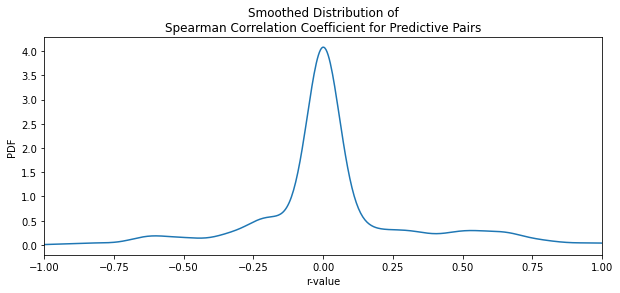

In [33]:
corr_data
plt.figure(figsize=(10,4))
ax = corr_data.r.plot.density(bw_method='scott')
ax.set_title('Smoothed Distribution of\nSpearman Correlation Coefficient for Predictive Pairs');
ax.set_xlabel('r-value');
ax.set_ylabel('PDF');
ax.set_xlim([-1,1]);


In [37]:
# # Groupby each variable and sort/filter to find pairs with |r| > 0.1
# corr_summary = corr_data.groupby(by='Y')
# for x in corr_summary.groups:
#     if ('Percent Change ' + quote_asset in corr_summary.get_group(x).index):
#         corr_summary.get_group(x).sort_values(by='r',ascending=False)[np.abs(corr_summary.get_group(x)['r'])>0.10]

In [27]:
# Find variables that correlate with |r| > 0.1 to predict Maker-Taker Volume Ratio
df([entry[1] for entry in df(complete_data.corr()['Maker-Taker Volume ' + quote_asset + ' Ratio']).transpose()[[colname for colname in complete_data.columns if not 'BTC' in colname]].transpose().sort_values(by='Maker-Taker Volume ' + quote_asset + ' Ratio',ascending=False).iterrows() if np.abs(entry[1][0]) > 0.1] )

# Find variables that correlate with |r| > 0.1 to predict Percent Price Change
df([entry[1] for entry in df(complete_data.corr()['Percent Change ' + quote_asset]).transpose()[[colname for colname in complete_data.columns if not 'BTC' in colname]].transpose().sort_values(by='Percent Change ' + quote_asset,ascending=False).iterrows() if np.abs(entry[1][0] > 0.1) ])


Maker-Taker Volume BTC Ratio
Taker Buy Volume ETH                      -0.22231

Percent Change BTC
Taker Buy Volume ETH             0.10685

In [28]:
# Create a table of lagged correlations between all variables and Price Change %
lagged_correlation = df.from_dict(
    {x: [complete_data['Percent Change ' + quote_asset].corr(complete_data[x].shift(t)) for t in range(20)] for x in complete_data.columns})
lagged_correlation = lagged_correlation*100

# Filter to find correlations for proportional distributions only,
# since we are only interested in scale-invariant predictors with compact support
x_corr_vol = lagged_correlation[[col for col in lagged_correlation.columns if 'Ratio' in col and 'LAG ' not in col]].transpose().style.background_gradient(cmap=sb.color_palette("coolwarm", as_cmap=True),axis=None).set_precision(1);
x_corr_vol

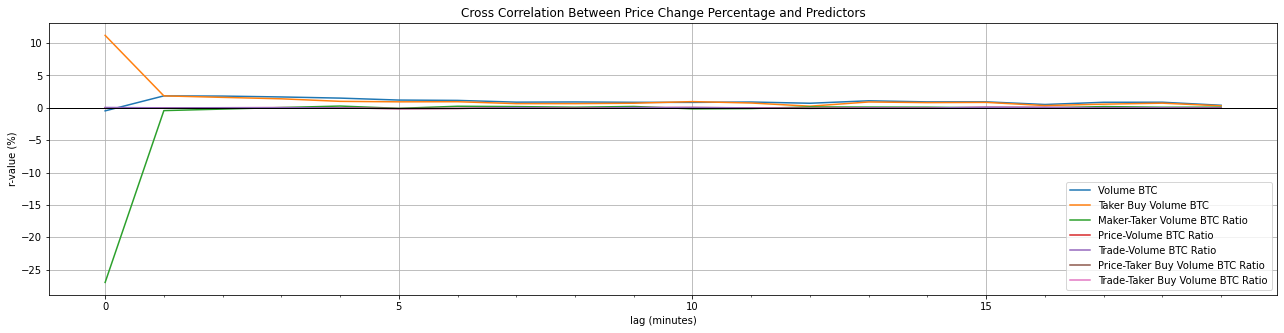

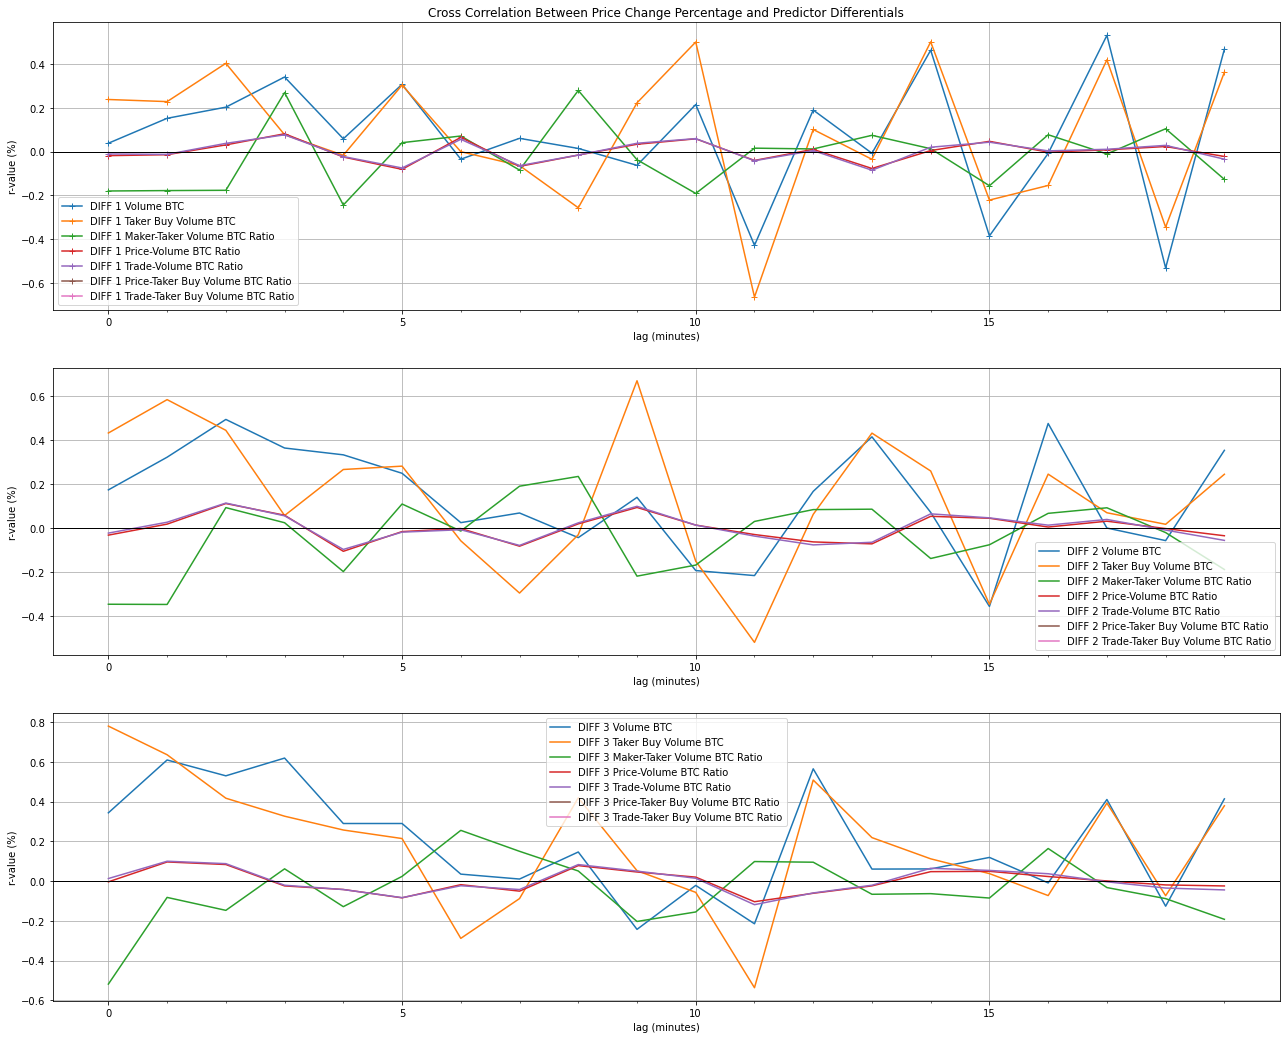

In [29]:
plt.figure(figsize=(22,5));
plt.plot(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF ' not in col and 'LAG ' not in col)]]);
plt.legend(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF ' not in col and 'LAG ' not in col)]].columns);
plt.axhline(y=0, c='k', lw=1);
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.title('Cross Correlation Between Price Change Percentage and Predictors');
plt.ylabel('r-value (%)');
plt.xlabel('lag (minutes)');
plt.grid('both')


fig, axs = plt.subplots(nrows=3,figsize=(22,6*3))
axs[0].plot(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 1' in col)]],marker='+');
axs[0].legend(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 1' in col)]]);

axs[1].plot(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 2' in col)]]);
axs[1].legend(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 2' in col)]]);

axs[2].plot(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 3' in col)]]);
axs[2].legend(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 3' in col)]]);



axs[0].set_title('Cross Correlation Between Price Change Percentage and Predictor Differentials');
for x in axs: x.set_ylabel('r-value (%)');
for x in axs: x.set_xlabel('lag (minutes)');
for x in axs: x.set_xticks(range(0,lagged_correlation.shape[0]));
for x in axs: x.grid('both');
for x in axs: x.axhline(y=0, c='k', lw=1);
for x in axs: x.xaxis.set_major_locator(plt.MultipleLocator(5));
for x in axs: x.xaxis.set_minor_locator(plt.MultipleLocator(1));

Maker-Taker Ratio Kurtosis = -0.32462105


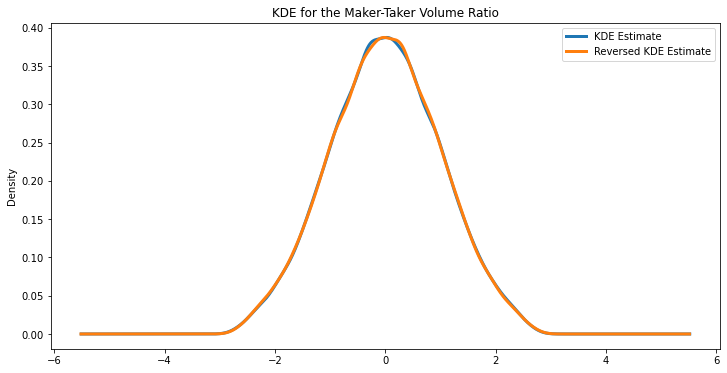

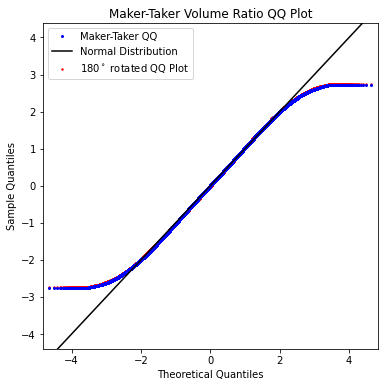

In [30]:
InteractiveShell.ast_node_interactivity = "last_expr"
# check normality assumption in Maker-Taker Volume Ratio

# plot KDE, and flip for visual symmetry check
mtvol_sample = complete_data.sample(16000)['Maker-Taker Volume ' + quote_asset + ' Ratio'];

mtvol_desc_stats = mtvol_sample.describe();
mtvol_sample_normalized = (mtvol_sample - mtvol_desc_stats['mean']) / mtvol_desc_stats['std'];

# plot QQ, and flip 180 deg for visual symmetry check
ax = plt.figure(figsize=(12,6));
mtvol_sample_normalized.plot.kde(lw=3,label='KDE Estimate');

(-1.0*mtvol_sample_normalized).plot.kde(lw=3,label='Reversed KDE Estimate');
plt.legend();

plt.title('KDE for the Maker-Taker Volume Ratio');

sm.qqplot(complete_data['Maker-Taker Volume ' + quote_asset + ' Ratio'],
fit=True,markersize=2,label='Maker-Taker QQ').set_size_inches((6,6));

ax = plt.gca();
ax.scatter(-ax.lines[0].get_xdata(),-ax.lines[0].get_ydata(),s=2,c='r',label='$180^\circ$ rotated QQ Plot');
ax.axline([-4,-4],[4,4],c='k',label='Normal Distribution');

plt.title('Maker-Taker Volume Ratio QQ Plot');
plt.legend();

print('Maker-Taker Ratio Kurtosis = ' + str(complete_data['Maker-Taker Volume ' + quote_asset + ' Ratio'].kurtosis()));



# distribution is appproximately normal with slight left-skew and slight negative kurtosis


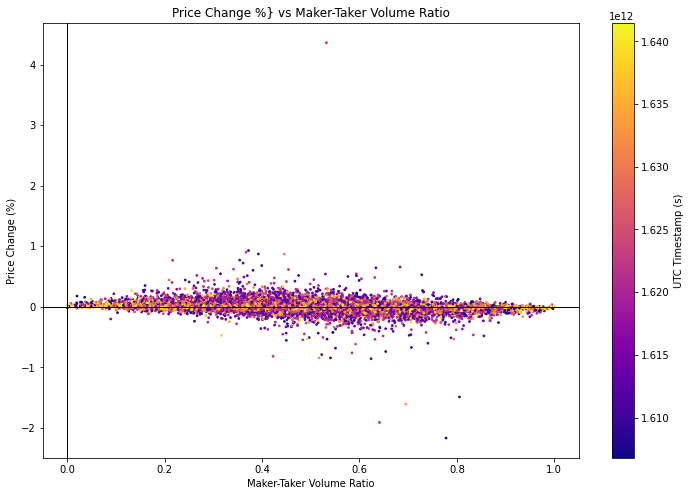

In [35]:
# Inspect the 
plot_sample = complete_data.sample(16000);


plt.figure(figsize=(12,8));
# ax = plt.axes(projection='3d')
plt.axhline(0,color='black',lw=1);
plt.axvline(0,color='black',lw=1);

x = (plot_sample['Maker-Taker Volume ' + quote_asset + ' Ratio']).to_numpy()

plt.scatter(x,plot_sample['Percent Change ' + quote_asset],
# c=plot_sample.index, ###
c=plot_sample.index,
s=3,alpha=1,cmap='plasma');
plt.colorbar().set_label('UTC Timestamp (s)');
plt.xlabel('Maker-Taker Volume Ratio');
plt.ylabel('Price Change (%)');
plt.title('Price Change %}' + ' vs ' + 'Maker-Taker Volume Ratio');

#ax=plt.gca();
#plt.xlim([0,1])
#plt.ylim([-2,2])

#ax.yaxis.set_ticks(np.arange(-2,2.2,0.2));

# plt.yscale('symlog',linthresh = 0.001);
# plt.xscale('symlog',linthresh = 0.001);

In [36]:
# # Plot all price difference - x pairs
# plot_sample = complete_data.sample(16000);

# for x in ( x for x in plot_sample.columns if 'Ratio' in x ):
#     plt.figure(figsize=(6,6));
#     # ax = plt.axes(projection='3d')
#     plt.axhline(0,color='black',lw=1);
#     plt.axvline(0,color='black',lw=1);

#     plt.scatter(
#         plot_sample[x],
#         plot_sample['Difference ' + quote_asset],
#         # c=plot_sample.index, ###
#         c=plot_sample.index,cmap='cool',
#         s=3,alpha=1);

#     # plt.colorbar();
#     plt.xlabel(x);
#     plt.ylabel('Price Difference %');
#     plt.title(x + ' vs ' + 'Price Difference %');
    

    #ax=plt.gca();
    #plt.xlim([0,1])
    #plt.ylim([-2,2])

    #ax.yaxis.set_ticks(np.arange(-2,2.2,0.2));

    # plt.yscale('symlog',linthresh = 0.001);
    # plt.xscale('symlog',linthresh = 0.001);
    # plt.yscale('logit');
